## Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from viz_preprocess import *
from viz_sequence import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


## Prepare Inputs

In [2]:
input_bed = pd.read_csv('/srv/www/encode4crisprhack/gkmexplain/inputs/caprin_dnase_intersection.hg38.input.bed', header=None, sep='\t')
input_chrom = input_bed[0].tolist()
input_start = input_bed[1].tolist()
input_end = input_bed[2].tolist()

fasta = '/srv/www/encode4crisprhack/gkmexplain/inputs/caprin_dnase_intersection.hg38.input.fa'
hyp_file = '/srv/www/encode4crisprhack/gkmexplain/outputs/caprin_dnase_intersection.hg38.hyp.scores'

seqs = [x.rstrip() for (i,x) in enumerate(open(fasta)) if i%2==1]
onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in seqs if ('N' not in x)]

print("Num onehot sequences:", len(onehot))

hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(hyp_file)], seqs) if 'N' not in w[1]]

imp_scores = get_impscores(hyp_scores, onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(imp_scores,
                                 onehot,
                                 hyp_scores)])) == 0

normed_imp_scores, normed_hyp_scores = normalize_scores(
    impscores=imp_scores, hyp_impscores=hyp_scores, onehot_data=onehot)

Num onehot sequences: 186


## Get Important Regions

In [3]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'score':[]}

for i,j in enumerate(seqs):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(input_chrom[i])
    seq_dict['start'].append(input_start[i])
    seq_dict['end'].append(input_end[i])
    seq_dict['score'].append(np.sum(imp_scores[i]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df = seq_df.drop_duplicates(['chr', 'start', 'end'])
seq_df.sort_values(by='score', ascending=False, inplace=True)
seq_df.head(20)

index    chr     start       end     score
184    184  chr11  34916289  34916789  1.885496
57      57  chr11  34161714  34162214  1.600509
165    165  chr11  34809562  34810062  1.383902
169    169  chr11  34826055  34826555  1.369535
25      25  chr11  33927065  33927565  1.323696
47      47  chr11  34052007  34052507  1.312324
88      88  chr11  34357845  34358345  1.293167
15      15  chr11  33892768  33893268  1.205242
112    112  chr11  34523068  34523568  1.202313
168    168  chr11  34820043  34820543  1.185856
74      74  chr11  34251066  34251566  1.163261
175    175  chr11  34850315  34850815  1.159668
76      76  chr11  34263374  34263874  1.145455
29      29  chr11  33941509  33942009  1.092460
9        9  chr11  33881821  33882321  1.054223
71      71  chr11  34242036  34242536  1.029761
60      60  chr11  34191535  34192035  1.015522
120    120  chr11  34585779  34586279  1.005158
127    127  chr11  34600202  34600702  0.988811
81      81  chr11  34302466  34302966  0.979532

## Visualize Top Sequences

Index:  184  Importance:  1.8854963125800004   chr11 : 34916289 - 34916789


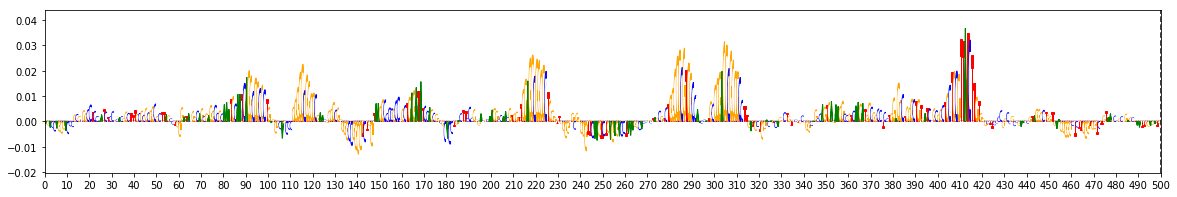

Index:  57  Importance:  1.6005092311999998   chr11 : 34161714 - 34162214


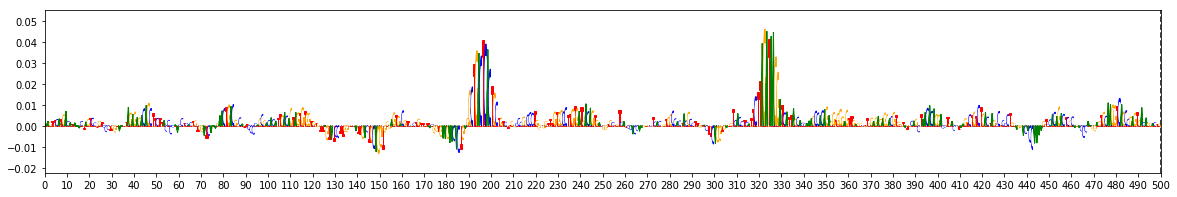

In [22]:
for idx in [184,57]:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'score'], ' ',
          seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    ylim = plot_weights(imp_scores[idx], subticks_frequency=10, xlim=(0,500))

Index:  184  Importance:  1.8854963125800004   chr11 : 34916289 - 34916789


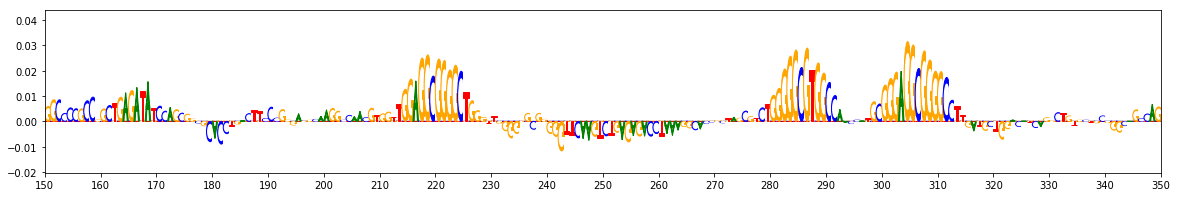

Index:  57  Importance:  1.6005092311999998   chr11 : 34161714 - 34162214


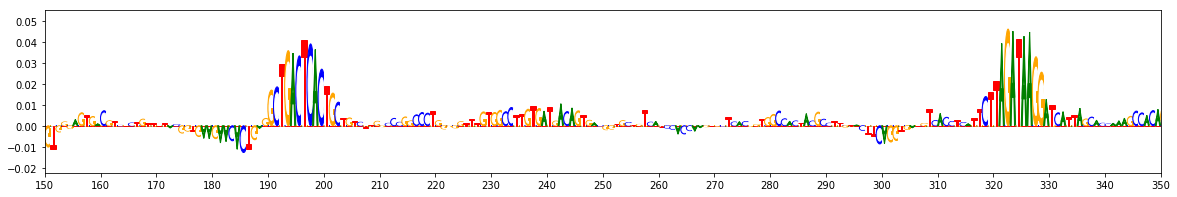

Index:  165  Importance:  1.38390194808   chr11 : 34809562 - 34810062


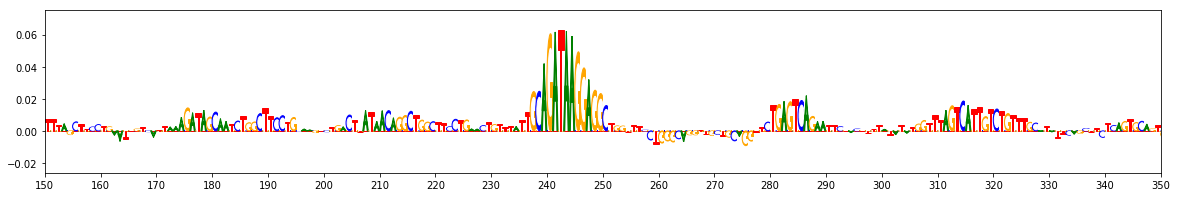

In [25]:
for idx in [184,57,165,]:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'score'], ' ',
          seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    ylim = plot_weights(imp_scores[idx], subticks_frequency=10, xlim=(150,350))

## Get Dinucleotide Shuffled Sequences

In [5]:
from deeplift.dinuc_shuffle import dinuc_shuffle

np.random.seed(1234)
random.seed(1234)

num_dinuc_shuffled_seqs = 186
#Generate the dinucleotide shuffled sequences and write to a file
fasta_seqs_no_N = [x.rstrip() for (i,x) in enumerate(open("/srv/www/encode4crisprhack/gkmexplain/inputs/caprin_enhancers_dnase_intersection.hg38.input.fa"))
                   if (i%2==1 and ('N' not in x))]
open("/srv/www/encode4crisprhack/gkmexplain/inputs/dnshuff_seqs.fa", 'w').write(
 "\n".join([">"+str(i)+"\n"+dinuc_shuffle(np.random.choice(fasta_seqs_no_N))
            for i in range(num_dinuc_shuffled_seqs)]))

94005

## Normalize Importance Scores

In [6]:
def normalize_scores(impscores, hyp_impscores, onehot_data):
  #normalize the hyp scores such that, at each position, hypothetical importance
  # scores that have the same sign as the original importance score all sum
  # up to the original importance score value. The rationale is that if
  # multiple different bases at a position could produce a similar score,
  # the specific identity of each individual base is less important.
  #Empirically, hypothetical scores like these appear to work better for
  # motif discovery. Using normalized importance scores derived by taking
  # the elementwise product of the normalized hypothetical scores and
  # the one-hot encoding also seems to reduce noise.
  normed_hyp_impscores = []
  normed_impscores = []
  for i in range(len(impscores)):
      imp_score_each_pos = np.sum(impscores[i],axis=-1)
      imp_score_sign_each_pos = np.sign(imp_score_each_pos)
      hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])
                                   *imp_score_sign_each_pos[:,None] > 0)
      hyp_scores_same_sign_imp_scores_sum = np.sum(
          hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
      norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
      norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
      normed_hyp_impscores.append(norm_hyp)
      normed_impscores.append(norm_hyp*onehot_data[i])
  return normed_impscores, normed_hyp_impscores

normed_impscores, normed_hyp_impscores = normalize_scores(
  impscores=imp_scores, hyp_impscores=hyp_scores, onehot_data=onehot)

## Get DnShuff Importance Scores

In [7]:
dnshuff_impscores = [np.array( [[float(z) for z in y.split(",")]
                           for y in x.rstrip().split("\t")[2].split(";")])
                     for x in open("/srv/www/encode4crisprhack/gkmexplain/outputs/dnshuff_impscores.txt")]

## Get Seqlets

On task task0
Computing windowed sums on original
Generating null dist
Computing threshold
Thresholds from null dist were -0.29635435700000007  and  0.6925867599999999
Passing windows frac was 0.0007504480286738351 , which is below  0.03 ; adjusting
Final raw thresholds are -0.2427712905299999  and  0.2427712905299999
Final transformed thresholds are -0.9699932795698925  and  0.9699932795698925


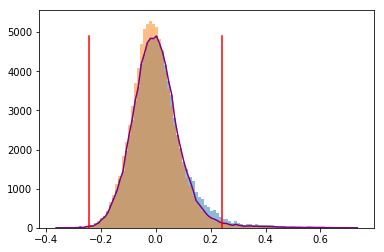

Got 179 coords
After resolving overlaps, got 179 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9699931795698925
179 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [159]
Idx to activities:  {0: '1'}
On metacluster 0
Metacluster size 159
Relevant tasks:  ('task0',)
Relevant signs:  (1,)


W0920 11:36:13.736875 139850002044672 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/modisco/backend/tensorflow_backend.py:87: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 159
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings


W0920 11:36:14.212583 139850002044672 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0920 11:36:14.213839 139850002044672 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0920 11:36:14.214616 139850002044672 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0920 11:36:14.263274 139850002044672 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_va

Finished embedding computation in 0.23 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.03 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.04 s
(Round 1) Compute nearest neighbors from coarse affmat


ValueError: Negative values in data passed to `pairwise_distances`. Precomputed distance  need to have non-negative values.

In [8]:
from modisco.visualization import viz_sequence
import h5py

dnshuff_perposimp = [np.sum(x,axis=-1) for x in dnshuff_impscores]

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
          #target_seqlet_fdr controls the stringency of the threshold used.
          # the default value is 0.2
          target_seqlet_fdr=0.15,
          #min_passing_windows_frac and max_passing_windows_frac can be used
          # to manually adjust the percentile cutoffs for importance
          # scores if you feel that the cutoff
          # defined by the null distribution is too stringent or too
          # lenient. The default values are 0.03 and 0.2 respectively.
          #min_passing_windows_frac=0.03,
          #max_passing_windows_frac=0.2
          seqlets_to_patterns_factory=
              modisco.tfmodisco_workflow
                     .seqlets_to_patterns
                     .TfModiscoSeqletsToPatternsFactory(
                  #kmer_len, num_gaps and num_mismatches are used to
                  # derive kmer embeddings for coarse-grained affinity
                  # matrix calculation. kmer_len=6, num_gaps=1
                  # and num_mismatches=0 means
                  # that kmer embeddings using 6-mers with 1 gap will be
                  # used. The default is to use longer kmers, but this
                  # can take a while to run and can lead to
                  # out-of-memory errors on some systems.
                  # Empirically, 6-mers with 1-gap
                  # seem to give good results.
                  kmer_len=6, num_gaps=1,
                  num_mismatches=0,
          ),
     )(
  #There is only one task, so we just call this 'task0'
  task_names=["task0"],
  contrib_scores={'task0': imp_scores},                
  hypothetical_contribs={'task0': hyp_scores},
  one_hot=onehot,
  null_per_pos_scores={'task0': dnshuff_perposimp})

## Visualize Seqlets

In [12]:
from modisco.aggregator import TrimToBestWindow

trimmer = TrimToBestWindow(window_size=30, track_names=["task0_contrib_scores"])

for i,pattern in enumerate(trimmer(tfmodisco_results
                                   .metacluster_idx_to_submetacluster_results[0]
                                   .seqlets_to_patterns_result.patterns)):
    print("num seqlets",len(pattern.seqlets))
    print("fwd seq PWM")
    viz_sequence.plot_weights(viz_sequence.ic_scale(
        pattern["sequence"].fwd, background=np.array([0.25,0.25,0.25,0.25])))
    print("Contrib scores")
    viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
    print("Hyp contrib scores")
    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
  
    print("rev seq PWM")
    viz_sequence.plot_weights(viz_sequence.ic_scale(
      pattern["sequence"].rev, background=np.array([0.25,0.25,0.25,0.25])))
    print("Contrib scores")
    viz_sequence.plot_weights(pattern["task0_contrib_scores"].rev)
    print("Hyp contrib scores")
    viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)

KeyError: 0